In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import PorterStemmer
import matplotlib.ticker as mtick
from urllib.parse import urlparse
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df_original = pd.read_csv('Entrenamieto_ECI_2020.csv')
df = df_original

In [4]:
df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.00,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.00,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.60,USD,83865.60,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.50,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.50,Closed Lost,Prod_Category_A_None


# Relacion entre Opportunity_Owner y Stages

In [5]:
df_opportunity = df[["Opportunity_Owner", "Account_Owner", "Stage", "Opportunity_Name"]].groupby("Opportunity_Name").agg(pd.Series.nunique)
df_opportunity[(df_opportunity["Opportunity_Owner"] != 1) | (df_opportunity["Stage"] != 1) | df_opportunity["Account_Owner"] != 1]

,Opportunity_Owner,Account_Owner,Stage
Opportunity_Name,,,


Esto significa que cada entrada del df es un item de una oportunidad, y todo los items tienen el mismo desenlace (valor Stage) y las oportunidades son manejadas por un único Opportunity_Owner y Account_Owner.

In [6]:
df_owners = df[["Opportunity_Owner", "Stage", "Opportunity_Name"]].drop_duplicates()
df_owners = df_owners[["Stage", "Opportunity_Owner"]]
df_owners.head()

,Stage,Opportunity_Owner
0,Closed Lost,Person_Name_18
1,Closed Won,Person_Name_20
2,Closed Won,Person_Name_8
3,Closed Lost,Person_Name_8
4,Closed Lost,Person_Name_8


In [7]:
df_owners = df_owners.astype({"Opportunity_Owner" : "category", "Stage" : "category"})
df_owners.dtypes

Stage                category
Opportunity_Owner    category
dtype: object

In [8]:
df_owners.describe()

,Stage,Opportunity_Owner
count,9841,9841
unique,5,53
top,Closed Won,Person_Name_50
freq,5072,958


In [9]:
df_owners = df_owners[(df_owners["Stage"] == "Closed Won") | (df_owners["Stage"] == "Closed Lost")]
df_owners.describe()

,Stage,Opportunity_Owner
count,9791,9791
unique,2,53
top,Closed Won,Person_Name_50
freq,5072,951


In [10]:
def mean_closed_wons(x):
    return (x == "Closed Won").mean()

In [11]:
df_owners

,Stage,Opportunity_Owner
0,Closed Lost,Person_Name_18
1,Closed Won,Person_Name_20
2,Closed Won,Person_Name_8
3,Closed Lost,Person_Name_8
4,Closed Lost,Person_Name_8
...,...,...
16939,Closed Won,Person_Name_13
16940,Closed Lost,Person_Name_13
16942,Closed Won,Person_Name_13
16945,Closed Lost,Person_Name_3


In [12]:
df_owners_mean_wins = df_owners.groupby("Opportunity_Owner").filter(lambda x: x["Stage"].count() > 50)

df_owners_mean_wins["Stage"] = df_owners_mean_wins["Stage"].apply(lambda x: 1 if (x == "Closed Won") else 0)

df_owners_mean_wins

,Stage,Opportunity_Owner
0,0,Person_Name_18
2,1,Person_Name_8
3,0,Person_Name_8
4,0,Person_Name_8
5,0,Person_Name_8
...,...,...
16939,1,Person_Name_13
16940,0,Person_Name_13
16942,1,Person_Name_13
16945,0,Person_Name_3


In [13]:
df_owners_top15_best = df_owners_mean_wins.groupby("Opportunity_Owner").agg({"Stage" : "mean"}).dropna()["Stage"].nlargest(15).to_frame().rename(columns = {"Stage": "Percentage Closed Wons"})
df_owners_top15_best

,Percentage Closed Wons
Opportunity_Owner,
Person_Name_19,0.97
Person_Name_52,0.78
Person_Name_32,0.77
Person_Name_64,0.68
Person_Name_65,0.68
Person_Name_66,0.66
Person_Name_55,0.65
Person_Name_50,0.63
Person_Name_33,0.60


Grafico el resultado

Text(0, 0.5, 'Opportunity Owner')

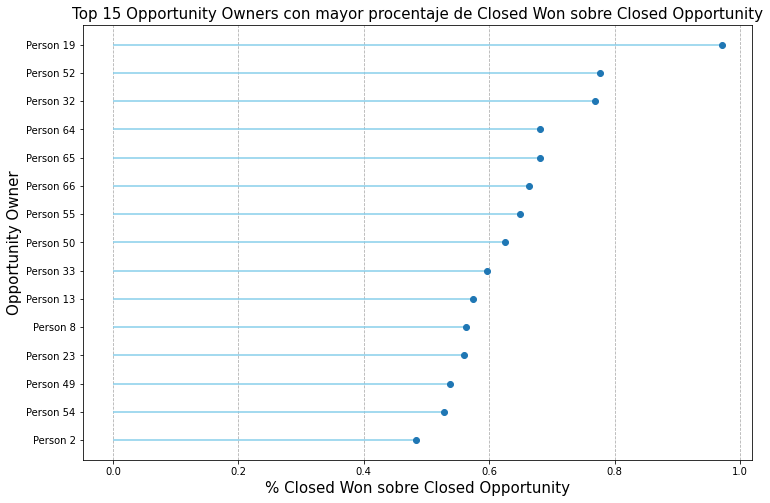

In [14]:
df_owners_top15_best = df_owners_top15_best.sort_values("Percentage Closed Wons", ascending = True)
df_owners_top15_best.index = df_owners_top15_best.index.str.replace("_Name_", " ", regex = True)

plt.subplots(figsize=(12,8))

plt.hlines(y = df_owners_top15_best.index, xmin = 0, xmax = df_owners_top15_best['Percentage Closed Wons'], color = 'skyblue')
plt.plot(df_owners_top15_best['Percentage Closed Wons'], df_owners_top15_best.index, "o")
 
# Add titles and axis names
plt.grid(True, axis = "x", ls = '--')
plt.yticks(rotation = 0)
plt.title("Top 15 Opportunity Owners con mayor procentaje de Closed Won sobre Closed Opportunity", loc = 'center', fontsize = 15)
plt.xlabel('% Closed Won sobre Closed Opportunity', fontsize = 15)
plt.ylabel('Opportunity Owner', fontsize = 15)


De la misma forma podemos ver los 15 peores Opportunity Owners 

In [15]:
df_owners_top15_worst = df_owners_mean_wins.groupby("Opportunity_Owner").agg({"Stage" : "mean"}).dropna()["Stage"].nsmallest(15).to_frame().rename(columns = {"Stage": "Percentage Closed Wons"})
df_owners_top15_worst

,Percentage Closed Wons
Opportunity_Owner,
Person_Name_45,0.21
Person_Name_5,0.23
Person_Name_60,0.25
Person_Name_39,0.25
Person_Name_16,0.27
Person_Name_3,0.29
Person_Name_59,0.30
Person_Name_43,0.31
Person_Name_63,0.32


(-0.05, 1.05)

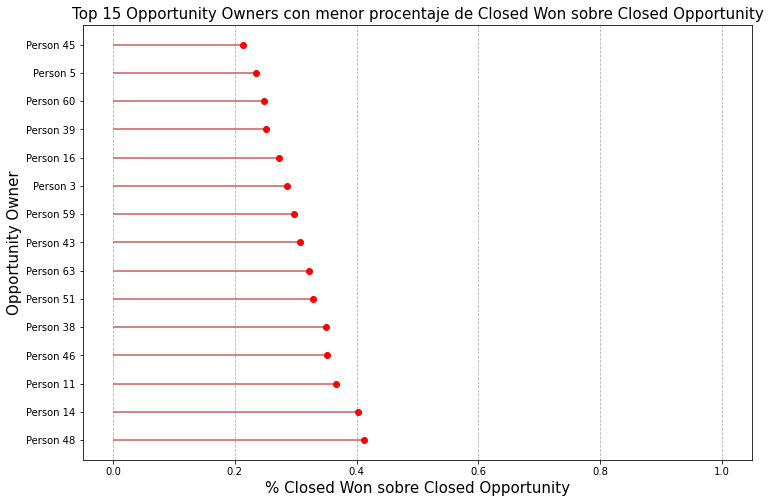

In [16]:
df_owners_top15_worst = df_owners_top15_worst.sort_values("Percentage Closed Wons", ascending = False)
df_owners_top15_worst.index = df_owners_top15_worst.index.str.replace("_Name_", " ", regex = True)

plt.subplots(figsize=(12,8))

plt.hlines(y = df_owners_top15_worst.index, xmin = 0, xmax = df_owners_top15_worst['Percentage Closed Wons'], color = 'indianred')
plt.plot(df_owners_top15_worst['Percentage Closed Wons'], df_owners_top15_worst.index, "o", c = "r", scalex = False)
 
# Add titles and axis names
plt.grid(True, axis = "x", ls = '--')
plt.yticks(rotation = 0)
plt.title("Top 15 Opportunity Owners con menor procentaje de Closed Won sobre Closed Opportunity", loc = 'center', fontsize = 15)
plt.xlabel('% Closed Won sobre Closed Opportunity', fontsize = 15)
plt.ylabel('Opportunity Owner', fontsize = 15)
plt.xlim(-0.05, 1.05)

### Verificacion Total_Taxable_Ammount

In [17]:
df_taxable = df[["Opportunity_Name", "Total_Amount", "Total_Taxable_Amount"]]

In [18]:
df_grouped = df_taxable.groupby("Opportunity_Name").agg({"Total_Amount" : "sum", "Total_Taxable_Amount" : "mean"})

df_grouped["Difference"] = df_grouped["Total_Amount"] - df_grouped["Total_Taxable_Amount"]
df_grouped

,Total_Amount,Total_Taxable_Amount,Difference
Opportunity_Name,,,
Opportunity_Name_0,3494400.00,3494400.00,0.00
Opportunity_Name_1,2193100.00,2193100.00,0.00
Opportunity_Name_100,543780.00,543780.00,0.00
Opportunity_Name_1000,142142000.00,142142000.00,0.00
Opportunity_Name_10000,19600.00,0.00,19600.00
...,...,...,...
Opportunity_Name_9992,175190.40,0.00,175190.40
Opportunity_Name_9995,1043490.00,1043490.00,0.00
Opportunity_Name_9996,790246.88,790246.88,0.00


In [19]:
df_true = df_grouped[(df_grouped["Difference"] != 0) & (df_grouped["Total_Taxable_Amount"] != 0)]
df_true

,Total_Amount,Total_Taxable_Amount,Difference
Opportunity_Name,,,
Opportunity_Name_10374,61755.05,61755.05,0.00
Opportunity_Name_10398,14120268.80,14120268.80,-0.00
Opportunity_Name_10429,167706.00,118671.10,49034.90
Opportunity_Name_10434,3440056.90,3440056.90,0.00
Opportunity_Name_10437,2273949.30,2273949.30,-0.00
...,...,...,...
Opportunity_Name_9735,1065049.70,1065049.70,0.00
Opportunity_Name_9806,972370.35,972370.35,0.00
Opportunity_Name_9843,964092.15,964092.15,-0.00


Estos son los que no tienen sentido

In [20]:
df_true = df_true[round(df_true["Difference"])  < 0]
df_true = df_true.reset_index()
df_true

,Opportunity_Name,Total_Amount,Total_Taxable_Amount,Difference
0,Opportunity_Name_11024,51408.00,51512.40,-104.40
1,Opportunity_Name_11864,43972.50,4891061.00,-4847088.50
2,Opportunity_Name_12137,317625.00,420750.00,-103125.00
3,Opportunity_Name_12362,71456.25,86418.75,-14962.50
4,Opportunity_Name_1308,11111133.92,28944810.10,-17833676.18
5,Opportunity_Name_2214,539956.80,60059395.00,-59519438.20
6,Opportunity_Name_2215,539956.80,60059395.00,-59519438.20
7,Opportunity_Name_224,12432.00,14061.76,-1629.76
8,Opportunity_Name_2802,310050.00,620100.00,-310050.00
9,Opportunity_Name_3463,776081.25,904354.07,-128272.82


### Relación entre Quote Type y Stages

In [21]:
df["Quote_Type"].value_counts()

Non Binding    16777
Binding          170
Name: Quote_Type, dtype: int64

Hay mayor cantidad de coutas Non Binding que Binding

In [22]:
df_filter = df[["Quote_Type", "Total_Amount", "Stage", "Opportunity_Name"]].groupby("Opportunity_Name").agg({"Quote_Type" : pd.Series.nunique})
df_filter[df_filter["Quote_Type"] != 1]

,Quote_Type
Opportunity_Name,


Con esto se prueba que a cada Oportunidad le corresponde un único tipo de cuota a todos los productos. Por lo tanto mi analisis lo voy a hacer pensando en oportunidades

In [23]:
df_quotes = df[["Quote_Type", "Total_Amount", "Stage", "Opportunity_Name"]]
df_quotes = df_quotes.astype({"Opportunity_Name" : "category", "Stage" : "category", "Quote_Type" : "category"})
df_quotes.dtypes

Quote_Type          category
Total_Amount         float64
Stage               category
Opportunity_Name    category
dtype: object

In [24]:
df_quotes["Total_Amount_By_Opportunity"] = df_quotes.groupby("Opportunity_Name")["Total_Amount"].transform("sum")
df_quotes.head()

,Quote_Type,Total_Amount,Stage,Opportunity_Name,Total_Amount_By_Opportunity
0,Non Binding,5272800.00,Closed Lost,Opportunity_Name_12598,5272800.00
1,Non Binding,48230.00,Closed Won,Opportunity_Name_12600,48230.00
2,Non Binding,83865.60,Closed Won,Opportunity_Name_469,83865.60
3,Non Binding,7421881.50,Closed Lost,Opportunity_Name_415,7421881.50
4,Non Binding,13357192.50,Closed Lost,Opportunity_Name_851,13357192.50


In [25]:
del df_quotes["Total_Amount"]
df_quotes.head()

,Quote_Type,Stage,Opportunity_Name,Total_Amount_By_Opportunity
0,Non Binding,Closed Lost,Opportunity_Name_12598,5272800.00
1,Non Binding,Closed Won,Opportunity_Name_12600,48230.00
2,Non Binding,Closed Won,Opportunity_Name_469,83865.60
3,Non Binding,Closed Lost,Opportunity_Name_415,7421881.50
4,Non Binding,Closed Lost,Opportunity_Name_851,13357192.50


In [26]:
df_quotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Quote_Type                   16947 non-null  category
 1   Stage                        16947 non-null  category
 2   Opportunity_Name             16947 non-null  category
 3   Total_Amount_By_Opportunity  16947 non-null  float64 
dtypes: category(3), float64(1)
memory usage: 595.9 KB


In [27]:
df_quotes = df_quotes.drop_duplicates()
df_quotes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 16946
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Quote_Type                   9841 non-null   category
 1   Stage                        9841 non-null   category
 2   Opportunity_Name             9841 non-null   category
 3   Total_Amount_By_Opportunity  9841 non-null   float64 
dtypes: category(3), float64(1)
memory usage: 589.4 KB


Ahora que tenemos el total por oportunidad, vamos a ver cual es la media por tipo de quota y tipo de stage


In [28]:
df_quotes_mean = df_quotes.groupby(["Stage", "Quote_Type"]).agg({"Total_Amount_By_Opportunity" : "mean"}).fillna(0)
df_quotes_mean


Total_Amount_By_Opportunity
Stage         Quote_Type                              
Closed Lost   Binding                       3089022.94
              Non Binding                   4693484.21
Closed Won    Binding                       6152164.26
              Non Binding                   1514894.97
Negotiation   Binding                             0.00
              Non Binding                   1119482.83
Proposal      Binding                             0.00
              Non Binding                  96069097.46
Qualification Binding                             0.00
              Non Binding                  83504393.44

In [29]:
df_quotes_mean2 = df_quotes_mean.reset_index()
df_quotes_mean2

,Stage,Quote_Type,Total_Amount_By_Opportunity
0,Closed Lost,Binding,3089022.94
1,Closed Lost,Non Binding,4693484.21
2,Closed Won,Binding,6152164.26
3,Closed Won,Non Binding,1514894.97
4,Negotiation,Binding,0.00
5,Negotiation,Non Binding,1119482.83
6,Proposal,Binding,0.00
7,Proposal,Non Binding,96069097.46
8,Qualification,Binding,0.00
9,Qualification,Non Binding,83504393.44


In [30]:
df_prueba = df_quotes.pivot_table(index = "Quote_Type", columns = "Stage", values = "Total_Amount_By_Opportunity", aggfunc = np.mean).fillna(0)
df_prueba.columns = df_prueba.columns.astype(list)
df_prueba = df_prueba.reset_index()
df_prueba

Stage,Quote_Type,Closed Lost,Closed Won,Negotiation,Proposal,Qualification
0,Binding,3089022.94,6152164.26,0.00,0.00,0.00
1,Non Binding,4693484.21,1514894.97,1119482.83,96069097.46,83504393.44


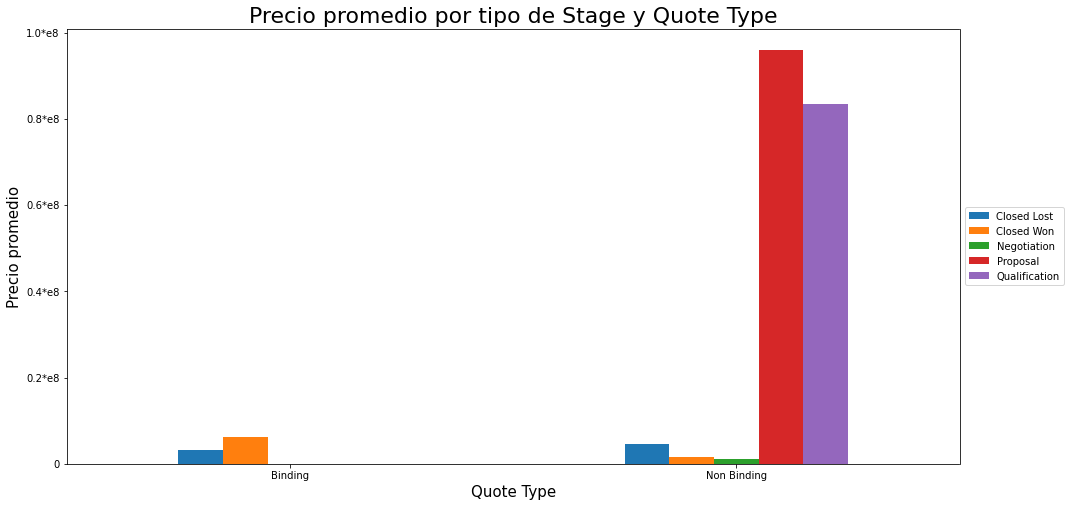

In [31]:
ax = df_prueba.plot(kind = "bar", x = 'Quote_Type', y = ['Closed Lost','Closed Won','Negotiation','Proposal','Qualification'], figsize = (16,8))
ax.set_title("Precio promedio por tipo de Stage y Quote Type", fontsize=22)
ax.set_xlabel("Quote Type",fontsize=15)
ax.set_ylabel("Precio promedio", fontsize=15)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:("{:.1f}*e8".format(x/1e8)) if x != 0 else ("{:.0f}".format(x))))
plt.xticks(rotation = 0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

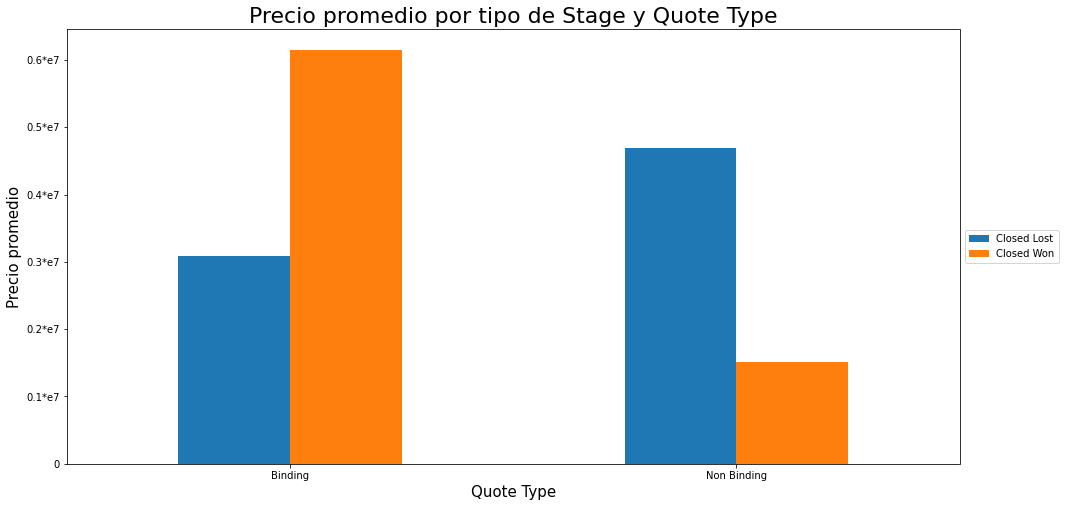

In [32]:
ax = df_prueba.plot(kind = "bar", x = 'Quote_Type', y = ['Closed Lost','Closed Won'], figsize = (16,8))
ax.set_title("Precio promedio por tipo de Stage y Quote Type", fontsize=22)
ax.set_xlabel("Quote Type",fontsize=15)
ax.set_ylabel("Precio promedio", fontsize=15)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:("{:.1f}*e7".format(x/1e7)) if x != 0 else ("{:.0f}".format(x))))
plt.xticks(rotation = 0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Analizo cantidad de closed wins y closed wins por tipo de cuota

In [33]:
df_quotes["Cuantity"] = 1
df_quotes.head()

,Quote_Type,Stage,Opportunity_Name,Total_Amount_By_Opportunity,Cuantity
0,Non Binding,Closed Lost,Opportunity_Name_12598,5272800.00,1
1,Non Binding,Closed Won,Opportunity_Name_12600,48230.00,1
2,Non Binding,Closed Won,Opportunity_Name_469,83865.60,1
3,Non Binding,Closed Lost,Opportunity_Name_415,7421881.50,1
4,Non Binding,Closed Lost,Opportunity_Name_851,13357192.50,1


In [34]:
df_pivot_quotes = df_quotes.pivot_table(index = "Quote_Type", columns = "Stage", values = "Cuantity", aggfunc = np.sum).fillna(0)
df_pivot_quotes.columns = df_pivot_quotes.columns.astype(list)
df_pivot_quotes = df_pivot_quotes.reset_index()
df_pivot_quotes

Stage,Quote_Type,Closed Lost,Closed Won,Negotiation,Proposal,Qualification
0,Binding,66.00,64.00,0.00,0.00,0.00
1,Non Binding,4653.00,5008.00,11.00,30.00,9.00


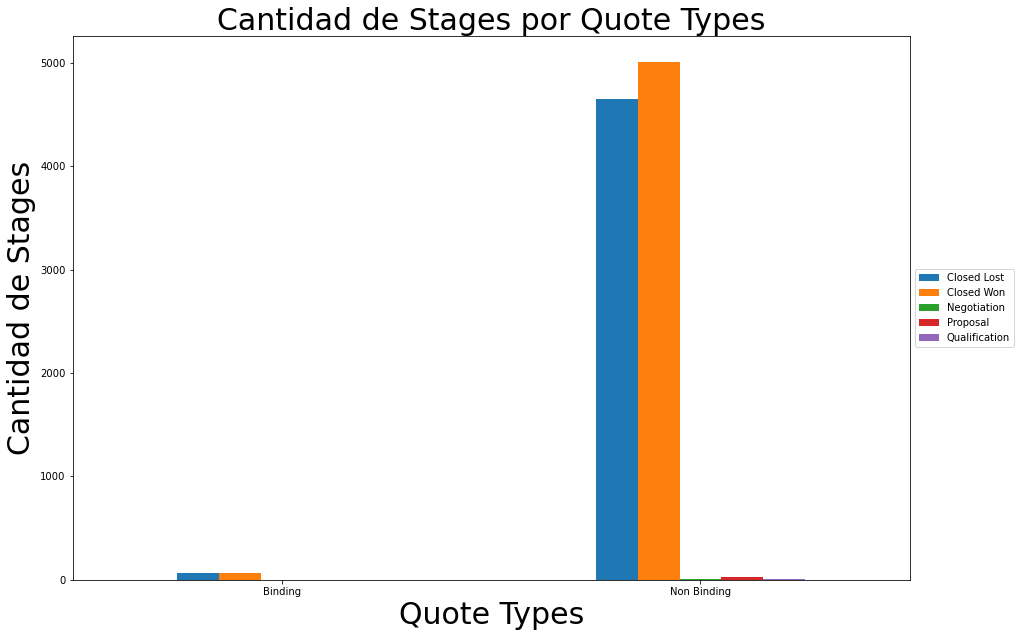

In [35]:
ax=df_pivot_quotes.plot(kind ='bar', y = ['Closed Lost', 'Closed Won', 'Negotiation', 'Proposal', 'Qualification'], x = 'Quote_Type' , figsize=(15,10))
ax.set_title("Cantidad de Stages por Quote Types", fontsize=30)
ax.set_xlabel("Quote Types",fontsize=30)
ax.set_ylabel("Cantidad de Stages", fontsize=30) 
plt.legend(prop={'size': 20})
plt.xticks(rotation = 0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Relacion Product Type con Stage por region

In [36]:
df_type = df[["Product_Type", "Stage", "Region"]]
df_type.describe()

,Product_Type,Stage,Region
count,16947,16947,16947
unique,7,5,5
top,None,Closed Won,Japan
freq,15935,9533,4892


In [37]:
df_filtered = df_type[(df_type["Product_Type"] != "None") & (df_type["Product_Type"] != "Other")]
df_filtered.describe()

,Product_Type,Stage,Region
count,497,497,497
unique,5,1,5
top,Product_Type_3,Closed Lost,EMEA
freq,179,497,282


In [38]:
df_grouped = df_filtered.groupby(["Region", "Product_Type"]).agg({"Stage" : "count"})
df_grouped = df_grouped.unstack().fillna(0)
df_grouped.columns = df_grouped.columns.get_level_values(1)
df_grouped.columns.name = ""
df_grouped = df_grouped.reset_index()
df_grouped

,Region,Product_Type_0,Product_Type_1,Product_Type_2,Product_Type_3,Product_Type_4
0,APAC,18.00,19.00,2.00,41.00,25.00
1,Americas,26.00,15.00,2.00,29.00,10.00
2,EMEA,45.00,90.00,5.00,105.00,37.00
3,Japan,4.00,10.00,0.00,1.00,1.00
4,Middle East,1.00,8.00,0.00,3.00,0.00


<Figure size 2520x2520 with 0 Axes>

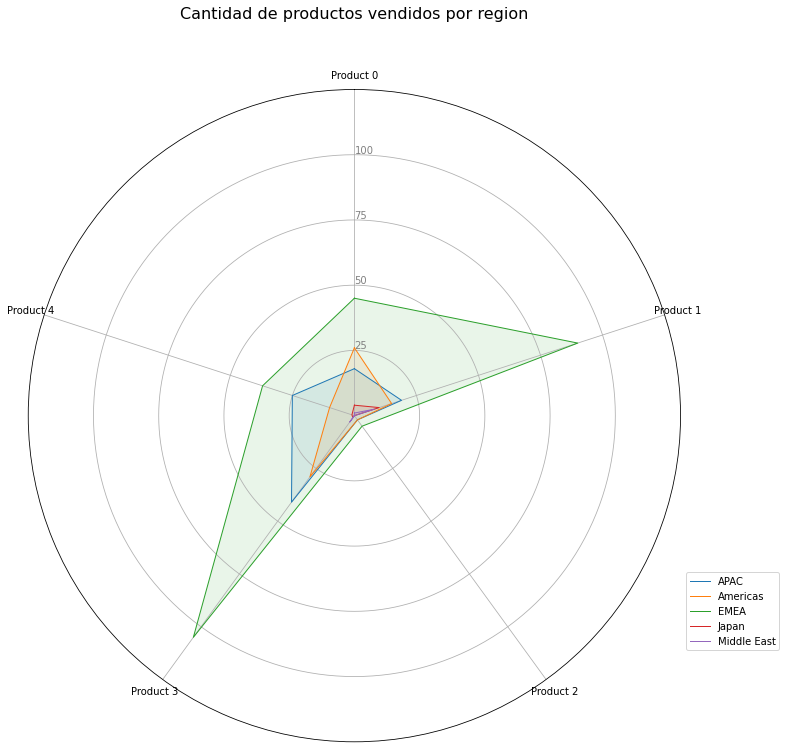

<Figure size 2520x2520 with 0 Axes>

In [39]:
plt.figure(figsize=(15,12))
# ------- PART 1: Create background
 
# number of variable
categories = [x.replace("_Type_", " ") for x in (list(df_grouped)[1:])]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
my_dpi=96
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([25, 50, 75, 100], ["25","50","75", "100"], color="grey", size=10)
plt.ylim(0,125)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df_grouped.loc[0].drop('Region').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="APAC",)
ax.fill(angles, values, 'tab:blue', alpha=0.1)
 
# Ind2
values=df_grouped.loc[1].drop('Region').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Americas")
ax.fill(angles, values, 'tab:orange', alpha=0.1)

# Ind3
values=df_grouped.loc[2].drop('Region').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="EMEA")
ax.fill(angles, values, 'tab:green', alpha=0.1)

# Ind4
values=df_grouped.loc[3].drop('Region').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Japan")
ax.fill(angles, values, 'tab:red', alpha=0.1)

# Ind5
values=df_grouped.loc[4].drop('Region').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Middle East")
ax.fill(angles, values, 'tab:purple', alpha=0.1)
 
# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.2))

#Add title
plt.title("Cantidad de productos vendidos por region", size=16, y=1.1)

#Change size
plt.figure(figsize = (35,35))


Ahora analizo su relacion con stage

In [40]:
df_region_type = df_filtered[df_filtered["Stage"] == "Closed Lost"]
df_region_type["Percentage Closed Wons"] = df_region_type["Stage"].apply(lambda x: 1 if (x == "Closed Won") else 0)
del df_region_type["Stage"]
df_region_type = df_region_type.groupby("Region").agg({"Percentage Closed Wons" : "mean"})
# df_region_type = df_grouped.unstack().fillna(0)
# df_region_type.columns = df_grouped.columns.get_level_values(1)
# df_region_type.columns.name = ""
# df_region_type = df_grouped.reset_index()
df_region_type

,Percentage Closed Wons
Region,
APAC,0
Americas,0
EMEA,0
Japan,0
Middle East,0


(-0.05, 1.05)

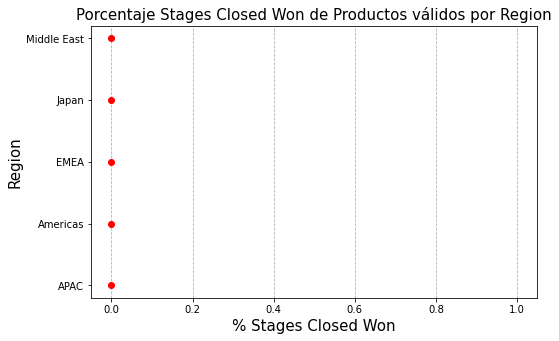

In [41]:

plt.figure(figsize=(8,5))
plt.hlines(y = df_region_type.index, xmin = 0, xmax = df_region_type['Percentage Closed Wons'], color = 'indianred')
plt.plot(df_region_type['Percentage Closed Wons'], df_region_type.index, "o", c = "r", scalex = False)
    
# Add titles and axis names
plt.grid(True, axis = "x", ls = '--')
plt.yticks(rotation = 0)
plt.title("Porcentaje Stages Closed Won de Productos válidos por Region", loc = 'center', fontsize = 15)
plt.xlabel('% Stages Closed Won', fontsize = 15)
plt.ylabel('Region', fontsize = 15)
plt.xlim(-0.05, 1.05)

# df_owners_top15_worst = df_owners_top15_worst.sort_values("Percentage Closed Wons", ascending = False)
# df_owners_top15_worst.index = df_owners_top15_worst.index.str.replace("_Name_", " ", regex = True)

# plt.subplots(figsize=(12,8))

# plt.hlines(y = df_owners_top15_worst.index, xmin = 0, xmax = df_owners_top15_worst['Percentage Closed Wons'], color = 'indianred')
# plt.plot(df_owners_top15_worst['Percentage Closed Wons'], df_owners_top15_worst.index, "o", c = "r", scalex = False)
 
# # Add titles and axis names
# plt.grid(True, axis = "x", ls = '--')
# plt.yticks(rotation = 0)
# plt.title("Top 15 Opportunity Owners con menor procentaje de Closed Won sobre Closed Opportunity", loc = 'center', fontsize = 15)
# plt.xlabel('% Closed Won sobre Closed Opportunity', fontsize = 15)
# plt.ylabel('Opportunity Owner', fontsize = 15)
# plt.xlim(-0.05, 1.05)


Todos los Closed Lost tienen un tipo de producto asociado?

In [42]:
df_lost_type = df_type[df_type["Stage"] == "Closed Lost"]["Product_Type"].value_counts().to_frame()
df_lost_type

,Product_Type
None,6338
Other,515
Product_Type_3,179
Product_Type_1,142
Product_Type_0,94
Product_Type_4,73
Product_Type_2,9


Text(0.5, 1.0, 'Cantidad de tipos de productos de items de oportunidades Closed Lost')

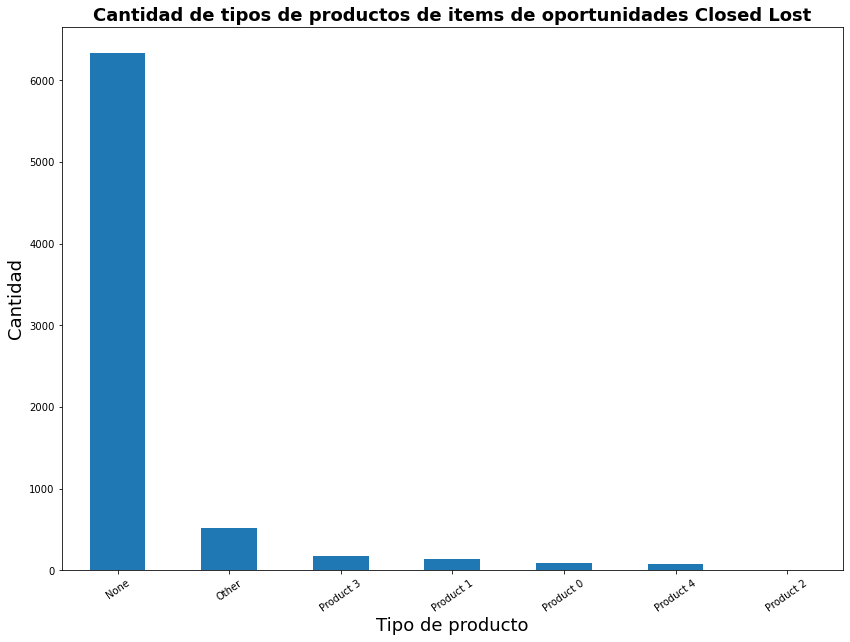

In [43]:
df_lost_type.index = [x.replace("_Type_", " ") for x in df_lost_type.index.astype(list)]

df_lost_type.plot(kind = "bar", rot = 35, figsize =  (14,10))
ax = plt.gca()
ax.set_ylabel("Cantidad", fontsize = 18)
ax.set_xlabel("Tipo de producto", fontsize = 18)
ax.get_legend().remove()
plt.title("Cantidad de tipos de productos de items de oportunidades Closed Lost", fontsize = 18, fontweight = "bold")

### Los que el taxable amount supera el 50% del precio total, tiene mas probabilidades de ser closed lost?

In [45]:
df["Opportunity_Name"].value_counts()

Opportunity_Name_5036     36
Opportunity_Name_9795     36
Opportunity_Name_12179    26
Opportunity_Name_11461    26
Opportunity_Name_6835     24
                          ..
Opportunity_Name_6755      1
Opportunity_Name_6638      1
Opportunity_Name_9203      1
Opportunity_Name_8005      1
Opportunity_Name_10560     1
Name: Opportunity_Name, Length: 9841, dtype: int64

In [63]:
df_logico = pd.merge(df, df_true, on = ['Opportunity_Name','Opportunity_Name'], how = "outer", indicator = True)
df_logico = df_logico[df_logico['_merge'] == 'left_only']
df_logico["Opportunity_Name"].value_counts()

Opportunity_Name_5036     36
Opportunity_Name_9795     36
Opportunity_Name_12179    26
Opportunity_Name_11461    26
Opportunity_Name_6835     24
                          ..
Opportunity_Name_7729      1
Opportunity_Name_6755      1
Opportunity_Name_6638      1
Opportunity_Name_9203      1
Opportunity_Name_10560     1
Name: Opportunity_Name, Length: 9822, dtype: int64

In [64]:
df_logico.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source ',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currenc

In [65]:
df_logico.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16913 entries, 0 to 16946
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ID                                  16913 non-null  int64   
 1   Region                              16913 non-null  object  
 2   Territory                           16913 non-null  object  
 3   Pricing, Delivery_Terms_Quote_Appr  16913 non-null  int64   
 4   Pricing, Delivery_Terms_Approved    16913 non-null  int64   
 5   Bureaucratic_Code_0_Approval        16913 non-null  int64   
 6   Bureaucratic_Code_0_Approved        16913 non-null  int64   
 7   Submitted_for_Approval              16913 non-null  int64   
 8   Bureaucratic_Code                   16913 non-null  object  
 9   Account_Created_Date                16913 non-null  object  
 10  Source                              16913 non-null  object  
 11  Billing_Country             

In [66]:
del df_logico["Total_Amount_y"]
del df_logico["Total_Taxable_Amount_y"]
del df_logico["Difference"]
del df_logico["_merge"]

In [67]:
df_logico.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16913 entries, 0 to 16946
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  16913 non-null  int64  
 1   Region                              16913 non-null  object 
 2   Territory                           16913 non-null  object 
 3   Pricing, Delivery_Terms_Quote_Appr  16913 non-null  int64  
 4   Pricing, Delivery_Terms_Approved    16913 non-null  int64  
 5   Bureaucratic_Code_0_Approval        16913 non-null  int64  
 6   Bureaucratic_Code_0_Approved        16913 non-null  int64  
 7   Submitted_for_Approval              16913 non-null  int64  
 8   Bureaucratic_Code                   16913 non-null  object 
 9   Account_Created_Date                16913 non-null  object 
 10  Source                              16913 non-null  object 
 11  Billing_Country                     16913

In [74]:
df_logico_2 = df_logico[["Opportunity_Name", "Total_Amount_x", "Total_Taxable_Amount_x", "Stage"]]
df_logico_2["Stage"] = df_logico_2["Stage"].apply(lambda x: 1 if (x == "Closed Won") else 0)
df_logico_2 = df_logico_2.groupby("Opportunity_Name").agg({"Total_Amount_x" : "sum", "Total_Taxable_Amount_x" : "mean", "Stage" : "mean"})
df_logico_2 =  df_logico_2.reset_index()
df_logico_2 = df_logico_2.groupby("Opportunity_Name").filter(lambda x : x["Total_Taxable_Amount_x"] > x["Total_Amount_x"] / 2)
df_logico_2

<ipython-input-74-e92cc778f4d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logico_2["Stage"] = df_logico_2["Stage"].apply(lambda x: 1 if (x == "Closed Won") else 0)


,Opportunity_Name,Total_Amount_x,Total_Taxable_Amount_x,Stage
0,Opportunity_Name_0,3494400.00,3494400.00,0
1,Opportunity_Name_1,2193100.00,2193100.00,0
2,Opportunity_Name_100,543780.00,543780.00,1
3,Opportunity_Name_1000,142142000.00,142142000.00,0
5,Opportunity_Name_10001,43352.70,43352.70,1
...,...,...,...,...
9816,Opportunity_Name_9991,323190.00,323190.00,1
9818,Opportunity_Name_9995,1043490.00,1043490.00,0
9819,Opportunity_Name_9996,790246.88,790246.88,0
9820,Opportunity_Name_9997,3799810.00,3799810.00,0


In [77]:
porcentaje_won = df_logico_2["Stage"].mean()
porcentaje_won

0.5357733436225334

Text(0.5, 1.0, 'Probabilidades de Closed Opportunity para oportunidades con alto valor impositivo')

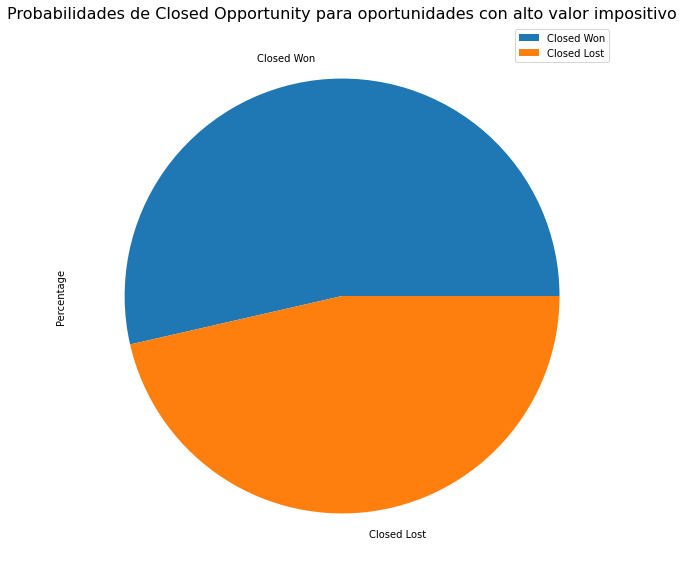

In [83]:
df_porcentaje = pd.DataFrame({'Percentage' : [porcentaje_won, 1 - porcentaje_won]}, index = ["Closed Won", "Closed Lost"])
df_porcentaje.plot(kind = "pie", y = "Percentage", figsize = (14, 10), subplots = True)
plt.title("Probabilidades de Closed Opportunity para oportunidades con alto valor impositivo", fontsize = 16)

In [84]:
df_logico_3 = df_logico[["Opportunity_Name", "Total_Amount_x", "Total_Taxable_Amount_x", "Stage"]]
df_logico_3["Stage"] = df_logico_3["Stage"].apply(lambda x: 1 if (x == "Closed Won") else 0)
df_logico_3 = df_logico_3.groupby("Opportunity_Name").agg({"Total_Amount_x" : "sum", "Total_Taxable_Amount_x" : "mean", "Stage" : "mean"})
df_logico_3 =  df_logico_3.reset_index()
df_logico_3 = df_logico_3.groupby("Opportunity_Name").filter(lambda x : x["Total_Taxable_Amount_x"] < x["Total_Amount_x"] / 2)
df_logico_3

<ipython-input-84-4b6dac2dfe56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logico_3["Stage"] = df_logico_3["Stage"].apply(lambda x: 1 if (x == "Closed Won") else 0)


,Opportunity_Name,Total_Amount_x,Total_Taxable_Amount_x,Stage
4,Opportunity_Name_10000,19600.00,0.00,0
316,Opportunity_Name_10308,3700695.60,0.00,0
317,Opportunity_Name_10309,741607.65,0.00,0
428,Opportunity_Name_10445,104328.00,0.00,0
429,Opportunity_Name_10446,93024.00,0.00,0
...,...,...,...,...
9737,Opportunity_Name_9911,25603200.00,0.00,0
9738,Opportunity_Name_9912,38700000.00,0.00,0
9739,Opportunity_Name_9913,12801600.00,0.00,0
9740,Opportunity_Name_9914,10660557.60,0.00,0


In [85]:
porcentaje_won_2 = df_logico_3["Stage"].mean()
porcentaje_won_2

0.29235382308845576

Text(0.5, 1.0, 'Probabilidades de Closed Opportunity para oportunidades con alto valor impositivo')

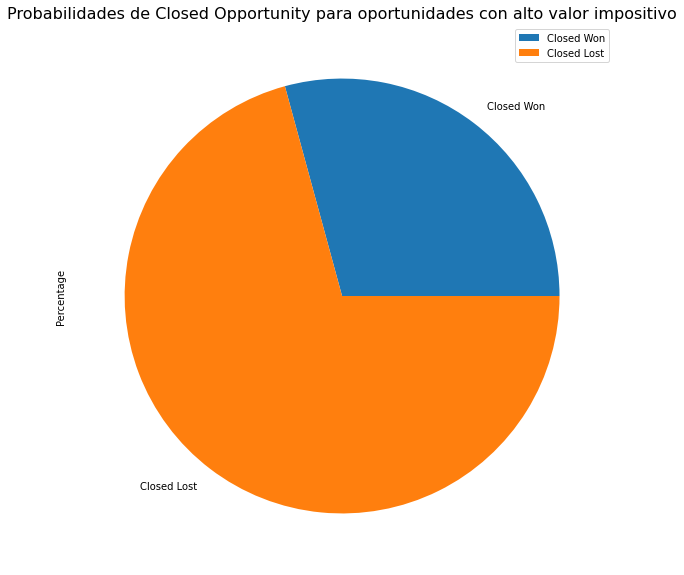

In [86]:
df_porcentaje_2 = pd.DataFrame({'Percentage' : [porcentaje_won_2, 1 - porcentaje_won_2]}, index = ["Closed Won", "Closed Lost"])
df_porcentaje_2.plot(kind = "pie", y = "Percentage", figsize = (14, 10), subplots = True)
plt.title("Probabilidades de Closed Opportunity para oportunidades con alto valor impositivo", fontsize = 16)

Tener mas del promedio de total amount, da probabilidades altas de closed won?